In [34]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/3high-3low/100iid',
           'vm/new/5high-5low/0iid', 'vm/new/5high-5low/100iid',
           'vm/new/10high-10low/0iid', 'vm/new/10high-10low/100iid',
           'vm/new/4high-2low/0iid', 'vm/new/4high-2low/100iid',
           'vm/new/8high-4low/0iid', 'vm/new/8high-4low/100iid',
           'vm/new/2high-4low/0iid', 'vm/new/2high-4low/100iid',
           'vm/new/4high-8low/0iid', 'vm/new/4high-8low/100iid',
           'vm/new/2high-8low/0iid', 'vm/new/2high-8low/100iid']

selected_confs = ['fixed-selector', 'random-selector', 'tree-selector', 'no-selector']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector)

              Exp Name N. Clients  High-Spec Clients  Low-Spec Clients  \
5    random-selector_4          3                  3                 3   
11   random-selector_4          6                  3                 3   
14   random-selector_4          3                  3                 3   
17   random-selector_4          3                  3                 3   
20   random-selector_4          3                  3                 3   
..                 ...        ...                ...               ...   
87    fixed-selector_6          2                  2                 8   
89    fixed-selector_6          2                  2                 8   
91    fixed-selector_6          2                  2                 8   
101   fixed-selector_6         10                  2                 8   
103   fixed-selector_6          2                  2                 8   

     IID Data  FL Round  Selector  Total Time of FL Round  Previous F1/Time  \
5           0         2      Tru

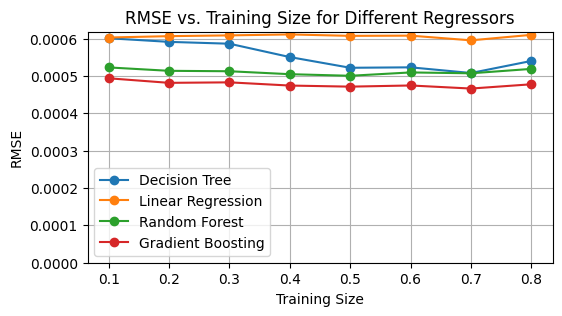

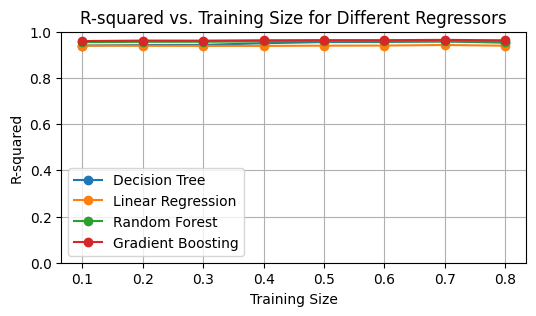

In [44]:
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    # n_jobs=-1 uses all available cores
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

train_size = np.arange(0.1, 0.9, 0.1)

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.figure(figsize=(6,3))
for name, scores in all_rmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.title('RMSE vs. Training Size for Different Regressors')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.savefig('plots/rq1/rq1_rmse_selector.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(6,3))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.title('R-squared vs. Training Size for Different Regressors')
plt.xlabel('Training Size')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.savefig('plots/rq1/rq1_rsquared_selector.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
folders = ['vm/new/3high-3low/0iid',
           'vm/new/5high-5low/0iid',
           'vm/new/4high-2low/0iid',
           'vm/new/2high-4low/0iid']
selected_confs = ['always-hdh', 'fixed-hdh', 'random-hdh']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_hdh[(exp_data_hdh['High-Spec Clients'] == 3) & (exp_data_hdh['Exp Name'] == 'random-hdh_1')][
          ['Exp Name', 'Client ID', 'FL Round', 'Previous JSD', 'HDH', 'Filled F1']])

         Exp Name  Client ID  FL Round  Previous JSD    HDH  Filled F1
6    random-hdh_1          1         2          0.36  False     0.0375
7    random-hdh_1          2         2          0.29  False     0.0375
8    random-hdh_1          3         2          0.43  False     0.0375
9    random-hdh_1          4         2          0.26  False     0.0375
10   random-hdh_1          5         2          0.38  False     0.0375
..            ...        ...       ...           ...    ...        ...
115  random-hdh_1          2        20          0.05   True     0.4170
116  random-hdh_1          3        20          0.15  False     0.4170
117  random-hdh_1          4        20          0.07   True     0.4170
118  random-hdh_1          5        20          0.13   True     0.4170
119  random-hdh_1          6        20          0.10  False     0.4170

[114 rows x 6 columns]


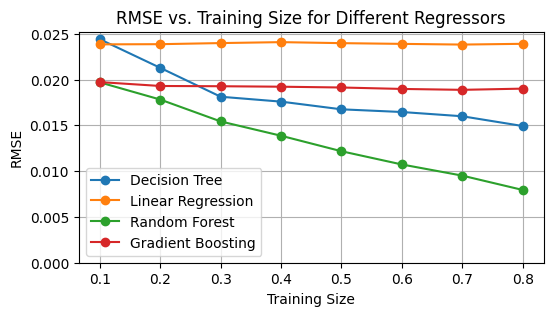

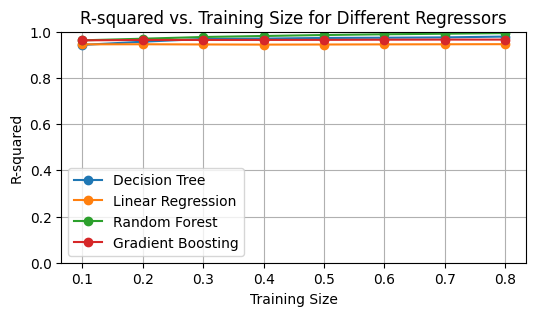

In [45]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    # n_jobs=-1 uses all available cores
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

train_size = np.arange(0.1, 0.9, 0.1)

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.figure(figsize=(6,3))
for name, scores in all_rmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.title('RMSE vs. Training Size for Different Regressors')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.savefig('plots/rq1/rq1_rmse_hdh.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(6,3))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.title('R-squared vs. Training Size for Different Regressors')
plt.xlabel('Training Size')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.savefig('plots/rq1/rq1_rsquared_hdh.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
folders = ['vm/same/3high-3low/0iid', 'vm/same/3high-3low/100iid',
           'vm/same/5high-5low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/4high-2low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/2high-4low/0iid', 'vm/same/2high-4low/100iid', ]
selected_confs = ['always-compressor', 'no-compressor', 'always-compressor-delay', 'no-compressor-delay']
exp_data_compressor: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor = pd.concat([exp_data_compressor, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_compressor[
          (exp_data_compressor['High-Spec Clients'] == 3) & (exp_data_compressor['Exp Name'] == 'no-compressor_1')][
          ['Exp Name', 'Client ID', 'FL Round', 'Compressor', 'Previous Communication Time', 'Total Time of FL Round']])

            Exp Name  Client ID  FL Round  Compressor  \
6    no-compressor_1         23         2       False   
7    no-compressor_1         24         2       False   
8    no-compressor_1         25         2       False   
9    no-compressor_1         26         2       False   
10   no-compressor_1         27         2       False   
..               ...        ...       ...         ...   
115  no-compressor_1         24        20       False   
116  no-compressor_1         25        20       False   
117  no-compressor_1         26        20       False   
118  no-compressor_1         27        20       False   
119  no-compressor_1         28        20       False   

     Previous Communication Time  Total Time of FL Round  
6                          22.74                     NaN  
7                          24.30                     NaN  
8                          23.83                     NaN  
9                          23.40                     NaN  
10                  

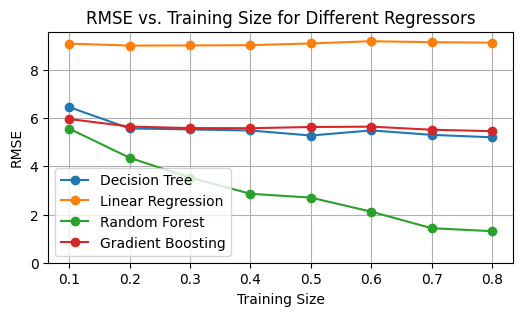

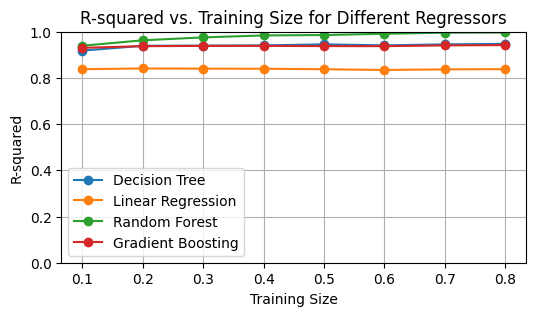

In [46]:
x = exp_data_compressor[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']]
y = exp_data_compressor[['Filled Total Time']]

# --- Regressors to Compare ---
regressors = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    # n_jobs=-1 uses all available cores
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

train_size = np.arange(0.1, 0.9, 0.1)

# Dictionaries to store scores for each regressor
all_rmse_scores = {name: [] for name in regressors.keys()}
all_r2_scores = {name: [] for name in regressors.keys()}

# --- Main Loop to Evaluate Regressors ---
for size in train_size:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1 - size), random_state=42)

    for name, regressor_model in regressors.items():
        regressor_model.fit(x_train, y_train.values.ravel())  # .values.ravel() for single-column y

        y_pred = regressor_model.predict(x_test)

        # Calculate RMSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        all_rmse_scores[name].append(rmse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        all_r2_scores[name].append(r2)

# Subplot 1: RMSE
plt.figure(figsize=(6,3))
for name, scores in all_rmse_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.title('RMSE vs. Training Size for Different Regressors')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.savefig('plots/rq1/rq1_rmse_compressor.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Subplot 2: R-squared
plt.figure(figsize=(6,3))
for name, scores in all_r2_scores.items():
    plt.plot(train_size, scores, marker='o', label=name)
plt.title('R-squared vs. Training Size for Different Regressors')
plt.xlabel('Training Size')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.savefig('plots/rq1/rq1_rsquared_compressor.pdf', dpi=300, bbox_inches='tight')
plt.show()